<a href="https://colab.research.google.com/github/parekhakhil/pyImageSearch/blob/main/1902_face_reco_lbps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

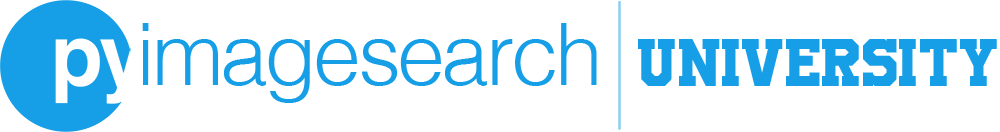

# Face Recognition with Local Binary Patterns (LBPs) and OpenCV
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch University](https://pyimg.co/university)** Jupyter Notebooks!

This notebook is associated with the [Face Recognition with Local Binary Patterns (LBPs) and OpenCV](https://www.pyimagesearch.com/2021/05/03/face-recognition-with-local-binary-patterns-lbps-and-opencv/) blog post published on 2021-05-03.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch University Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2021 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch University at https://pyimg.co/university today.*

### Download the code zip file

In [ ]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/face-reco-lbps/face-reco-lbps.zip
!unzip -qq face-reco-lbps.zip
%cd face-reco-lbps

## Blog Post Code

### Import Packages

In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import time
import cv2
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [ ]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Creating our face detector

In [ ]:
def detect_faces(net, image, minConfidence=0.5):
	# grab the dimensions of the image and then construct a blob
	# from it
	(h, w) = image.shape[:2]
	blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network to obtain the face detections,
	# then initialize a list to store the predicted bounding boxes
	net.setInput(blob)
	detections = net.forward()
	boxes = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > minConfidence:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# update our bounding box results list
			boxes.append((startX, startY, endX, endY))

	# return the face detection bounding boxes
	return boxes

### Loading the CALTECH Faces dataset

In [ ]:
def load_face_dataset(inputPath, net, minConfidence=0.5,
	minSamples=15):
	# grab the paths to all images in our input directory, extract
	# the name of the person (i.e., class label) from the directory
	# structure, and count the number of example images we have per
	# face
	imagePaths = list(paths.list_images(inputPath))
	names = [p.split(os.path.sep)[-2] for p in imagePaths]
	(names, counts) = np.unique(names, return_counts=True)
	names = names.tolist()

	# initialize lists to store our extracted faces and associated
	# labels
	faces = []
	labels = []

	# loop over the image paths
	for imagePath in imagePaths:
		# load the image from disk and extract the name of the person
		# from the subdirectory structure
		image = cv2.imread(imagePath)
		name = imagePath.split(os.path.sep)[-2]

		# only process images that have a sufficient number of
		# examples belonging to the class
		if counts[names.index(name)] < minSamples:
			continue

		# perform face detection
		boxes = detect_faces(net, image, minConfidence)

		# loop over the bounding boxes
		for (startX, startY, endX, endY) in boxes:
			# extract the face ROI, resize it, and convert it to
			# grayscale
			faceROI = image[startY:endY, startX:endX]
			faceROI = cv2.resize(faceROI, (47, 62))
			faceROI = cv2.cvtColor(faceROI, cv2.COLOR_BGR2GRAY)

			# update our faces and labels lists
			faces.append(faceROI)
			labels.append(name)

	# convert our faces and labels lists to NumPy arrays
	faces = np.array(faces)
	labels = np.array(labels)

	# return a 2-tuple of the faces and labels
	return (faces, labels)

### Implementing Local Binary Patterns for face recognition

In [ ]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", type=str, required=True,
# 	help="path to input directory of images")
# ap.add_argument("-f", "--face", type=str,
# 	default="face_detector",
# 	help="path to face detector model directory")
# ap.add_argument("-c", "--confidence", type=float, default=0.5,
# 	help="minimum probability to filter weak detections")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"input": "caltech_faces",
	"face": "face_detector",
    "confidence": 0.5,
}

In [ ]:
# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([args["face"], "deploy.prototxt"])
weightsPath = os.path.sep.join([args["face"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

In [ ]:
# load the CALTECH faces dataset
print("[INFO] loading dataset...")
(faces, labels) = load_face_dataset(args["input"], net,
	minConfidence=0.5, minSamples=20)
print("[INFO] {} images in dataset".format(len(faces)))

# encode the string labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)

# construct our training and testing split
(trainX, testX, trainY, testY) = train_test_split(faces,
	labels, test_size=0.25, stratify=labels, random_state=42)

In [ ]:
# train our LBP face recognizer
print("[INFO] training face recognizer...")
recognizer = cv2.face.LBPHFaceRecognizer_create(
	radius=2, neighbors=16, grid_x=8, grid_y=8)
start = time.time()
recognizer.train(trainX, trainY)
end = time.time()
print("[INFO] training took {:.4f} seconds".format(end - start))

In [ ]:
# initialize the list of predictions and confidence scores
print("[INFO] gathering predictions...")
predictions = []
confidence = []
start = time.time()

# loop over the test data
for i in range(0, len(testX)):
	# classify the face and update the list of predictions and
	# confidence scores
	(prediction, conf) = recognizer.predict(testX[i])
	predictions.append(prediction)
	confidence.append(conf)

# measure how long making predictions took
end = time.time()
print("[INFO] inference took {:.4f} seconds".format(end - start))

# show the classification report
print(classification_report(testY, predictions,
	target_names=le.classes_))

In [ ]:
# generate a sample of testing data
idxs = np.random.choice(range(0, len(testY)), size=10, replace=False)

# loop over a sample of the testing data
for i in idxs:
	# grab the predicted name and actual name
	predName = le.inverse_transform([predictions[i]])[0]
	actualName = le.classes_[testY[i]]

	# grab the face image and resize it such that we can easily see
	# it on our screen
	face = np.dstack([testX[i]] * 3)
	face = imutils.resize(face, width=250)

	# draw the predicted name and actual name on the image
	cv2.putText(face, "pred: {}".format(predName), (5, 25),
		cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
	cv2.putText(face, "actual: {}".format(actualName), (5, 60),
		cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

	# display the predicted name, actual name, and confidence of the
	# prediction (i.e., chi-squared distance; the *lower* the distance
	# is the *more confident* the prediction is)
	print("[INFO] prediction: {}, actual: {}, confidence: {:.2f}".format(
		predName, actualName, confidence[i]))

	# display the current face to our screen
	plt_imshow("Face", face)

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Face Recognition with Local Binary Patterns (LBPs) and OpenCV*](https://www.pyimagesearch.com/2021/05/03/face-recognition-with-local-binary-patterns-lbps-and-opencv/) published on 2021-05-03.

# Code License Agreement
```
Copyright (c) 2021 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```